# Mod 4 Project - Notebook

Jeremy Owens, Jeremy Reikes

# Step 1: Load the Data

In [2]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
# import seaborn as sns
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
# from dateutil.relativedelta import relativedelta
# from fbprophet import Prophet
import datetime as datetime
import warnings

from ProcessData import *
from narrow_zips import *

%matplotlib inline

In [3]:
initial_data = pd.read_csv('zillow_data.csv')
print(len(initial_data))
initial_data.head(10)

14723


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500


In [4]:
initial_data[initial_data['2014-06'].isna()].head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2946,73623,35810,Huntsville,AL,Huntsville,Madison,2947,NaN,NaN,NaN,...,61000,61000,61100,61900,62800,63200,63700,65200,67500,69400
3330,58630,2116,Boston,MA,Boston,Suffolk,3331,NaN,NaN,NaN,...,1931100,1995600,2031100,2049600,2057800,2064500,2037600,2056900,2106500,2136500
6153,73629,35816,Huntsville,AL,Huntsville,Madison,6154,NaN,NaN,NaN,...,61500,62500,62800,63300,64100,65100,66600,68700,70400,71300
7587,78091,46320,Hammond,IN,Chicago,Lake,7588,NaN,NaN,NaN,...,66000,67900,68200,68700,69600,69400,68500,68500,68200,67200
7635,78566,47371,Portland,IN,NaN,Jay,7636,NaN,NaN,NaN,...,86300,86600,87400,88200,89100,90300,90400,89100,88000,88100


In [5]:
# def fix_zipcodes(zipcode):
#     if len(zipcode) == 5:
#         return zipcode
#     else:
#         return '0'+zipcode

For the majority of our analysis, the only data we care about is zipcode and time series data for average home sale price in that zipcode each month, so we can eliminate the other columns in the dataframe.

We also noticed that the zipcodes (named RegionName) were all cast as integers, which eliminated any leading zeros that existed for places like New Jersey. The code below accomplishes both tasks.

In [7]:
# cut_data = initial_data.drop(['RegionID', 'City', 'State', 'CountyName', 'SizeRank', 'Metro'], axis=1)
# cut_data.rename({'RegionName': 'Zipcode'}, axis=1, inplace=True)
# cut_data['Zipcode'] = cut_data.Zipcode.astype(str)
# cut_data['Zipcode'] = cut_data['Zipcode'].apply(lambda z: fix_zipcodes(z))
# cut_data.head()

# Step 2: Data Preprocessing

In [8]:
# def get_datetimes(df):
#     return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [9]:
# cut_data.columns = [cut_data.columns[0]] + list(get_datetimes(cut_data))

# Step 3: Reshape from Wide to Long Format

For comparison sake, we melt the initial data set below to look at the growth in home values over time for all zipcodes.

In [12]:
# monthly_medians = melt_data(initial_data)

In [13]:
# monthly_medians.head()

,value
time,
1996-04-01,99500.0
1996-05-01,99500.0
1996-06-01,99700.0
1996-07-01,99700.0
1996-08-01,99800.0


In [8]:
processed_data = ProcessData()

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
monthly_medians = processed_data.monthly_medians
time_series = processed_data.dataframes
zipcodes = processed_data.zipcodes

In [19]:
time_series[0].drop('Prices', axis=1).head()

,Zipcode,City,State,Metro,CountyName,SizeRank,Price
Time,,,,,,,
1996-04-01,01001,Agawam,MA,Springfield,Hampden,5851,113100.0
1996-05-01,01001,Agawam,MA,Springfield,Hampden,5851,112800.0
1996-06-01,01001,Agawam,MA,Springfield,Hampden,5851,112600.0
1996-07-01,01001,Agawam,MA,Springfield,Hampden,5851,112300.0
1996-08-01,01001,Agawam,MA,Springfield,Hampden,5851,112100.0


In [20]:
# zipcodes = []
# time_series = []
# for row in range(len(cut_data)):
#     zipcodes.append(cut_data.iloc[row]['Zipcode'])
#     series = pd.DataFrame(cut_data.iloc[row].iloc[1:]).rename({row:'values'}, axis=1)
#     time_series.append(series)

In [21]:
# for zipcode in time_series:
#     for j in range(len(zipcode)):
#         if np.isnan(zipcode.iloc[-1-j].values[0]):
#             base = zipcode.iloc[-j].values[0]
#             ratio = monthly_medians.iloc[-1-j].values[0] / monthly_medians.iloc[-j].values[0]
#             zipcode.iloc[-1-j] = round(base * ratio, 2)

# Step 4: EDA and Visualization
Perform basic EDA as you would building any model, then create at least 3 visualizations.  At least one of the visualizations should have time on the x-axis.  Axes should be labeled and any text should be legible.

In [22]:
min(monthly_medians.values)

array([99500.])

We used http://www.in2013dollars.com/1996-dollars-in-2018?amount=99500 to get a table for inflation's effect on prices from 1996 (the beginning of our data set) to 2018 (the end of our dataset)

In [23]:
inflation_data = pd.read_csv('inflation_data.csv')
inflation_data['year'] = pd.to_datetime(inflation_data['year'], format='%Y')
inflation_data.drop('inflation rate', axis=1, inplace=True)
inflation_data.set_index('year', inplace=True)
inflation_data.head()

,amount
year,
1996-01-01,99500.000000
1997-01-01,101782.982792
1998-01-01,103368.387508
1999-01-01,105651.370300
2000-01-01,109202.676864


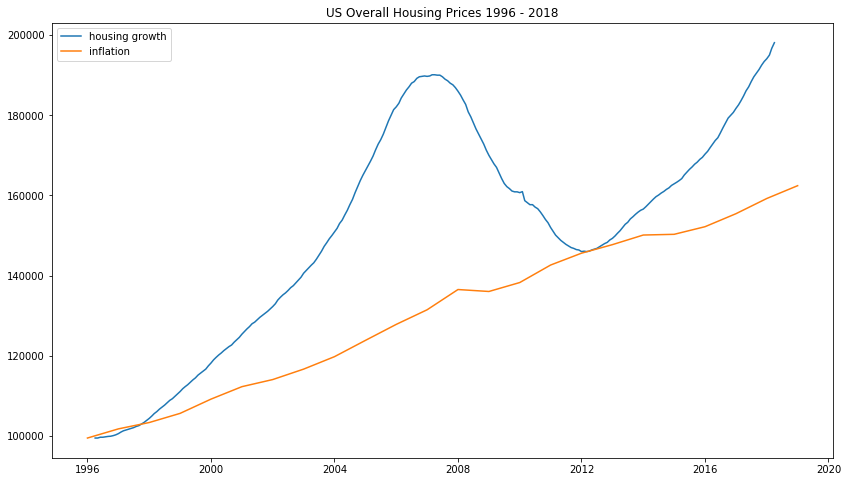

In [24]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(14,8))
plt.plot(monthly_medians, label='housing growth')
plt.plot(inflation_data, label='inflation')
plt.title('US Overall Housing Prices 1996 - 2018')
plt.legend()
plt.show()

In [38]:
raw_data = pd.io.parsers.read_csv('zillow_data.csv', dtype={'RegionName': 'str'})
widedata = raw_data
widedata.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [49]:
time_series[0].loc['2018'].Price

Time
2018-01-01    221700.0
2018-02-01    221700.0
2018-03-01    222700.0
2018-04-01    223600.0
Name: Price, dtype: float64

In [57]:
start_year='1996'
end_year='2018'
top_or_bottom='top'
how_many=5

percent_growth_by_zip = []
for zipcode in time_series:
    percent_for_zip = (zipcode.loc[end_year].Price[0] - zipcode.loc[start_year].Price[0]) / zipcode.loc[start_year].Price[0]
    percent_growth_by_zip.append(percent_for_zip)

start = 0
end = len(percent_growth_by_zip)
start = -how_many if top_or_bottom == 'top' else start
end = how_many if top_or_bottom == 'bottom' else end

indexes = sorted(range(len(percent_growth_by_zip)), 
                 key=lambda i: percent_growth_by_zip[i], reverse=False)[start:end]


In [82]:
start_year = '1996'
end_year = '2018'

percent_growth_by_zip = []
for zipcode in time_series:
    percent_for_zip = (zipcode.loc[end_year].Price[0] - zipcode.loc[start_year].Price[0]) / zipcode.loc[start_year].Price[0]
    percent_growth_by_zip.append(percent_for_zip)

In [83]:
sorted(percent_growth_by_zip)

[-0.19455252918287938,
 0.38833883388338836,
 0.4158878504672897,
 0.4356333676622039,
 0.47404063205417607,
 0.4937833037300178,
 0.5794621026894865,
 0.5934156378600823,
 0.6137820512820513,
 0.6178637200736649,
 0.6285434995112414,
 0.6365131578947368,
 0.654320987654321,
 0.6655791190864601,
 0.6659064994298746,
 0.6745689655172413,
 0.7014366021236728,
 0.7056229327453142,
 0.7106986899563319,
 0.7198480531813866,
 0.725287356321839,
 0.7261055634807418,
 0.7312961011591148,
 0.7331378299120235,
 0.7357859531772575,
 0.7404255319148936,
 0.7561174551386624,
 0.7642487046632125,
 0.768,
 0.7691154422788605,
 0.7711640211640212,
 0.7720170454545454,
 0.7905718701700154,
 0.7991587802313355,
 0.8251655629139073,
 0.8424884182660489,
 0.8430583501006036,
 0.8442211055276382,
 0.8472696245733788,
 0.8507042253521127,
 0.8508384819064431,
 0.8518987341772152,
 0.8566142460684552,
 0.8813033359193173,
 0.8839406207827261,
 0.8901098901098901,
 0.8978723404255319,
 0.9,
 0.900684931506849

In [77]:
def plot_growth(start_year='1996', end_year='2018', top_or_bottom='top', how_many=5):
    percent_growth_by_zip = []
    for zipcode in time_series:
        percent_for_zip = (zipcode.loc[end_year].Price[0] - zipcode.loc[start_year].Price[0]) / zipcode.loc[start_year].Price[0]
        percent_growth_by_zip.append(percent_for_zip)
        
    start = 0
    end = len(percent_growth_by_zip)
    start = -how_many if top_or_bottom == 'top' else start
    end = how_many if top_or_bottom == 'bottom' else end
    
    indexes = sorted(range(len(percent_growth_by_zip)), 
                     key=lambda i: percent_growth_by_zip[i], reverse=False)[start:end]
    
    values_to_print = []
    plt.figure(figsize=(14,8))
    for i in indexes:
        values_to_print.append([zipcodes[i], percent_growth_by_zip[i]])
        label = zipcodes[i]+' - '+ \
                widedata[widedata.RegionName == zipcodes[i]]['City'].values[0]+', '+ \
                widedata[widedata.RegionName == zipcodes[i]]['State'].values[0]

        plt.plot(time_series[i][start_year:end_year].Price, label=label)
    plt.plot(monthly_medians[start_year:end_year], label='Median growth')
    plt.legend()
    plt.show
    for j in range(len(values_to_print)):
        print('Growth rate for zipcode', values_to_print[j][0], ':', round(values_to_print[j][1]*100, 2), '%')

Growth rate for zipcode 90028 : 561.63 %
Growth rate for zipcode 90048 : 594.72 %
Growth rate for zipcode 90026 : 597.03 %
Growth rate for zipcode 90038 : 607.53 %
Growth rate for zipcode 90291 : 770.42 %


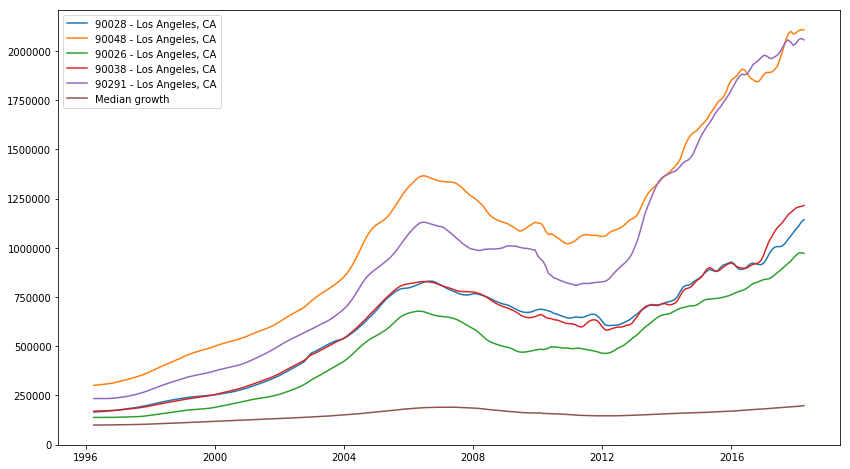

In [78]:
plot_growth(how_many=5)

Growth rate for zipcode 90291 : 102.54 %
Growth rate for zipcode 90066 : 108.05 %
Growth rate for zipcode 95389 : 110.61 %
Growth rate for zipcode 90210 : 123.06 %
Growth rate for zipcode 80010 : 149.07 %


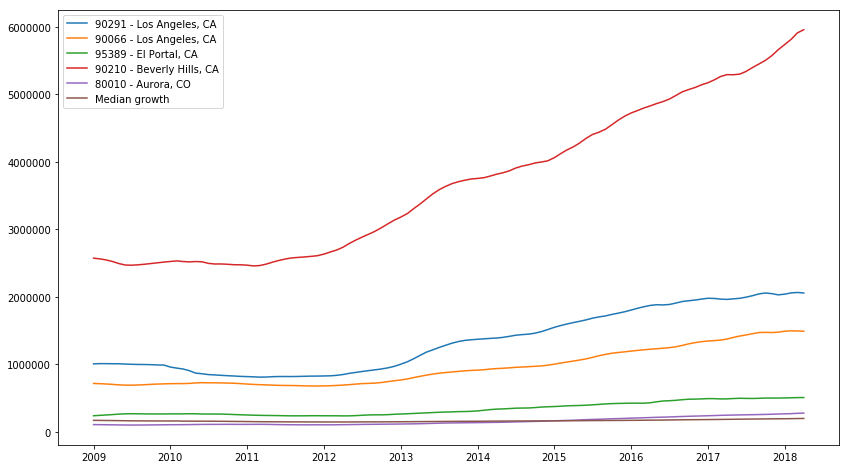

In [79]:
plot_growth(start_year='2009', end_year='2018', how_many=5)

In [25]:
# percent_growth_by_zip = []
# for zipcode in time_series:
#     numerator = zipcode.loc['2018'].values[0][0] - zipcode.loc['2010'].values[0][0]
#     percent_for_zip = numerator / zipcode.loc['2009'].values[0][0]
#     percent_growth_by_zip.append(percent_for_zip)

In [26]:
# indexes = sorted(range(len(percent_growth_by_zip)), 
#                  key=lambda i: percent_growth_by_zip[i], reverse=False)
# print(indexes[:5])

[1757, 1865, 14449, 14007, 6697]


In [28]:
# top_indexes = indexes[int(len(indexes)*.99):]
# len(top_indexes)

148

# Step 5: ARIMA Modeling
Be sure to validate your model.  Make a forecast for the future and describe the trend.

In [29]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(time_series, arima_order):
    # prepare training dataset
    time_series_filtered = time_series.squeeze()
    train_size = int(len(time_series_filtered) * 0.66)
    train, test = time_series_filtered[0:train_size], time_series_filtered[train_size:]
    history = [x for x in train]
    
    # make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [30]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(time_series, p_values, d_values, q_values):
    time_series = time_series.astype('float32')
    best_score, best_cfg = 100000000.0, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(time_series, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [ ]:
warnings.filterwarnings("ignore")
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 3)

# top_indexes should equal top_zipcodes from 

best_post_crash_arima = []
for index, zipcode in enumerate(time_series):
#     print('Index:', index, 'Zipcode:', zipcodes[index])
    pdq = evaluate_models(time_series[index], p_values, d_values, q_values)
#     print()
    best_post_crash_arima.append({'': index, 'zipcode': zipcodes[index], 'pdq': pdq})

In [40]:
warnings.filterwarnings("ignore")
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 3)

# top_indexes should equal top_zipcodes from 

best_post_crash_arima = []
for index in top_indexes[:3]:
    print('Index:', index, 'Zipcode:', zipcodes[index])
    pdq = evaluate_models(time_series[index], p_values, d_values, q_values)
    print()
    best_post_crash_arima.append({'index': index, 'zipcode': zipcodes[index], 'pdq': pdq})

Index: 2157 Zipcode: 98107
Best ARIMA(2, 1, 1) MSE=3080377.116

Index: 9540 Zipcode: 73103
Best ARIMA(2, 2, 0) MSE=1722197.843

Index: 13591 Zipcode: 95389
Best ARIMA(3, 1, 1) MSE=4332267.626



In [42]:
future_growth_by_zip_5_year = []
for entry in best_post_crash_arima:
    history = time_series[entry['index']].astype('float32')['2010':].squeeze()
    model = ARIMA(history, order=entry['pdq'])
    model_fit = model.fit(disp=0)
    model_predict = model_fit.forecast(12*5)
    future_percent_for_zip = (model_predict[0][-1] - history[-1]) / history[-1]
    future_growth_by_zip_5_year.append({'index': entry['index'],
                                        'zipcode': entry['zipcode'],
                                        'growth_predict': round(future_percent_for_zip*100, 2),
                                        'growth_values': model_predict[0]})

{'index': 2157, 'zipcode': '98107', 'pdq': (2, 1, 1)}
{'index': 9540, 'zipcode': '73103', 'pdq': (2, 2, 0)}
{'index': 13591, 'zipcode': '95389', 'pdq': (3, 1, 1)}


In [47]:
datelist = pd.date_range(pd.datetime(2018,5,1), periods=12*5, freq='MS').tolist()

In [48]:
for growth_entry in future_growth_by_zip_5_year:
    temp_df = pd.DataFrame(zip(datelist, growth_entry['growth_values'])).set_index(0)
    history_future_df = pd.concat([time_series[growth_entry['index']], 
                                   temp_df.rename({1:'values'}, axis=1).astype('int32')])
    growth_entry['all_values'] = history_future_df

# Step 6: Interpreting Results
Give a detailed interpretation of results including the relationship between the inputs and output of the model.

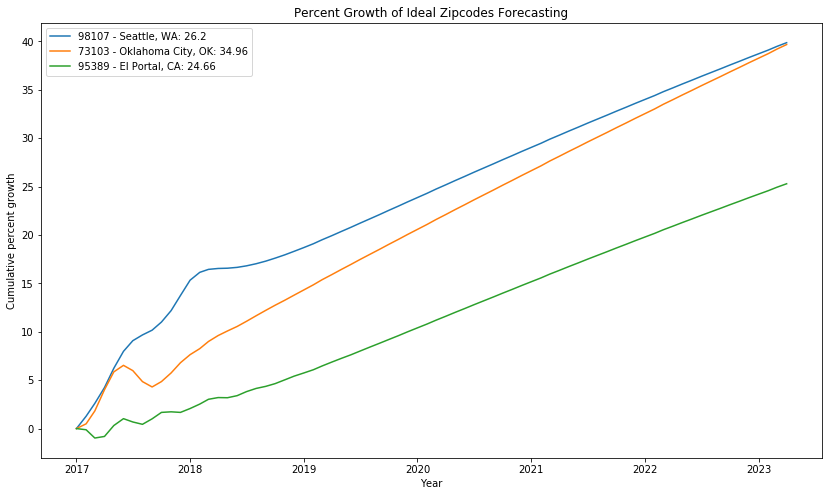

In [73]:
plt.figure(figsize=(14,8))
for growth_entry in future_growth_by_zip_5_year:
    percent_change_df = growth_entry['all_values']['2017':]
    percent_change = [0]
    for i in range(1, len(percent_change_df.values)):
        percent_change.append(100*((percent_change_df.values[i][0] - percent_change_df.values[i-1][0]) / percent_change_df.values[i-1][0]))
    percent_change_df['change'] = percent_change
    percent_change_df.drop('values', axis=1, inplace=True)
    percent_change_df = percent_change_df.cumsum()
    zipcode = growth_entry['zipcode']
    city = initial_data['City'][growth_entry['index']]
    state = initial_data['State'][growth_entry['index']]
    growth_rate = growth_entry['growth_predict']
    label = str(zipcode)+' - '+str(city)+', '+str(state)+': '+str(growth_rate)
    plt.plot(percent_change_df, label=label)
plt.ylabel('Cumulative percent growth')
plt.xlabel('Year')
plt.title('Percent Growth of Ideal Zipcodes Forecasting')
plt.legend()
plt.show()

# Working Zone

In [3]:
# to view all NaN values for median housing price in zip code
columns = list(initial_data.columns)
nans = list(initial_data.isna().sum())
for item in zip(columns, nans):
    print(item)

('RegionID', 0)
('RegionName', 0)
('City', 0)
('State', 0)
('Metro', 1043)
('CountyName', 0)
('SizeRank', 0)
('1996-04', 1039)
('1996-05', 1039)
('1996-06', 1039)
('1996-07', 1039)
('1996-08', 1039)
('1996-09', 1039)
('1996-10', 1039)
('1996-11', 1039)
('1996-12', 1039)
('1997-01', 1039)
('1997-02', 1039)
('1997-03', 1039)
('1997-04', 1039)
('1997-05', 1039)
('1997-06', 1039)
('1997-07', 1038)
('1997-08', 1038)
('1997-09', 1038)
('1997-10', 1038)
('1997-11', 1038)
('1997-12', 1038)
('1998-01', 1036)
('1998-02', 1036)
('1998-03', 1036)
('1998-04', 1036)
('1998-05', 1036)
('1998-06', 1036)
('1998-07', 1036)
('1998-08', 1036)
('1998-09', 1036)
('1998-10', 1036)
('1998-11', 1036)
('1998-12', 1036)
('1999-01', 1036)
('1999-02', 1036)
('1999-03', 1036)
('1999-04', 1036)
('1999-05', 1036)
('1999-06', 1036)
('1999-07', 1036)
('1999-08', 1036)
('1999-09', 1036)
('1999-10', 1036)
('1999-11', 1036)
('1999-12', 1036)
('2000-01', 1036)
('2000-02', 1036)
('2000-03', 1036)
('2000-04', 1036)
('2000-05

In [11]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 
                                  'CountyName', 'RegionID', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    return melted.groupby('time').agg({'value':'median'})

In [ ]:
for zipcode in time_series:
    for i in range(1, len(zipcode)+1):
        if zipcode.iloc[-i].values == 0:
            zipcode.iloc[-i] = round(float(zipcode.iloc[-i+1].values * (melted_data.iloc[-i].values / 
                                                                        melted_data.iloc[-i+1].values)), 0)

In [ ]:
percent_growth_by_zip = []
for zipcode in time_series:
    percent_for_zip = zipcode.loc['1996'].values[0][0] / zipcode.loc['2008'].values[0][0]
    percent_growth_by_zip.append(percent_for_zip)

In [ ]:
indexes = sorted(range(len(percent_growth_by_zip)), key=lambda i: percent_growth_by_zip[i], reverse=True)[:5]
indexes

In [ ]:
plt.figure(figsize=(14,8))
for i in indexes:
    plt.plot(time_series[i], label=str(zipcodes[i]))
plt.plot(monthly_medians, label='median growth')
plt.legend()
plt.show

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 13)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

In [137]:
# evaluate parameters
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(time_series[0], p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=22524201798.709
ARIMA(0, 0, 1) MSE=5644131313.729
ARIMA(0, 1, 0) MSE=15252790.551
ARIMA(0, 1, 1) MSE=6661495.112
ARIMA(0, 2, 0) MSE=11361751.352
ARIMA(0, 2, 1) MSE=7119207.778
ARIMA(1, 0, 0) MSE=25955172.117
ARIMA(1, 1, 0) MSE=9901379.810
ARIMA(1, 1, 1) MSE=5618165.173
ARIMA(1, 2, 0) MSE=9980796.512
ARIMA(1, 2, 1) MSE=7240391.272
ARIMA(1, 2, 2) MSE=6003944.604
ARIMA(2, 0, 0) MSE=10935372.639
ARIMA(2, 1, 0) MSE=6851567.523
ARIMA(2, 2, 0) MSE=6638567.862
ARIMA(2, 2, 1) MSE=6207464.714
ARIMA(2, 2, 2) MSE=5314251.194
ARIMA(3, 1, 1) MSE=5182165.450
ARIMA(3, 1, 2) MSE=3986375.863
ARIMA(3, 2, 0) MSE=6989774.563
ARIMA(3, 2, 1) MSE=6390995.761
ARIMA(4, 1, 0) MSE=5924929.777
ARIMA(4, 1, 1) MSE=5379103.854
ARIMA(4, 2, 0) MSE=4774411.464
ARIMA(4, 2, 1) MSE=5501008.573
ARIMA(4, 2, 2) MSE=5552039.614
ARIMA(5, 1, 0) MSE=4630496.045
ARIMA(5, 2, 0) MSE=5282916.710
ARIMA(5, 2, 1) MSE=5401434.905
ARIMA(6, 1, 0) MSE=5004262.883
ARIMA(6, 1, 1) MSE=4746351.866
ARIMA(6, 2, 0) MSE=5302217.7